In [9]:
#Mejor combinacion quitar outliers, valencia y loudness

In [10]:
#Preprocessing
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import math
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from libreria import *
from clase import *

#Models
from sklearn.decomposition import PCA
from sklearn.decomposition import PCA
from sklearn.manifold import MDS,TSNE
from sklearn.cluster import AgglomerativeClustering,KMeans
from sklearn.mixture import GaussianMixture

from varclushi import VarClusHi
from sklearn.metrics import silhouette_score

from scipy.stats import chisquare
from scipy.stats import kruskal
from statsmodels.stats.multicomp import MultiComparison

from itertools import chain
from functools import reduce

import matplotlib.pyplot as plt
import seaborn as sns
import cufflinks as cf
import plotly.express as px
import plotly.graph_objects as go

#Pickle
import pickle

#Graphics
from plotly.offline import plot,iplot

import warnings
warnings.filterwarnings('ignore')

## Datos

Para el análisis se utilizarán datos de la API de Spotify para poder identificar posibles grupos entre las distintas canciones, con el objetivo de crear si es posible un sistema de recomendacion de canciones basado en las canciones que un usuario suele escuchar normalmente.

Utilizaremos las transformaciones e ingeniería utilizados en proyectos anteriores para llegar a la tabla con la que vamos a trabajar, en general el proceso realiza lo siguiente:

1. Eliminar columnas de id, año y variables con multicolinealidad basado en el VIF.
2. Obtener el número de artistas en una canción apartir de la lista de artistas.
3. Obtener artista principal basado en la posición en la que aparecen.
4. Segmentar las canciones en 3 grupos de popularidad basado en la escala que maneja spotify (0-100).

Respecto a las variables continuas no se generó alguna ingeniería adicional puesto que representan distintos aspectos y características de la canción no relacionados.

In [11]:
df = pd.read_csv('data.csv')

pipeline_clean = Pipeline(steps=[('Headers', Headers()),
                ('Engineering',Engineering()),
                ('Drop Columns',Drop_columns()),
                ('Encode_popularity',Get_popularity())])

pipeline_clean.fit(df)

df = pipeline_clean.transform(df)

varc = list(df.filter(like='c_'))
vard = ['v_explicit', 'v_key', 'v_mode', 'v_popularity','v_num_artists']
varid = ['t_artist']

In [12]:
df.head()

,c_acousticness,c_danceability,c_duration_ms,c_energy,v_explicit,c_instrumentalness,v_key,c_liveness,v_mode,t_name,v_popularity,c_speechiness,c_tempo,c_valence,v_num_artists,t_artist
0,0.991000,0.598,168333,0.224,0,0.000522,5,0.3790,0,Keep A Song In Your Soul,Not popular,0.0936,149.976,0.6340,1,Mamie Smith
1,0.643000,0.852,150200,0.517,0,0.026400,5,0.0809,0,I Put A Spell On You,Not popular,0.0534,86.889,0.9500,1,Screamin Jay Hawkins
2,0.993000,0.647,163827,0.186,0,0.000018,0,0.5190,1,Golfing Papa,Not popular,0.1740,97.600,0.6890,1,Mamie Smith
3,0.000173,0.730,422087,0.798,0,0.801000,2,0.1280,1,True House Music - Xavier Santos & Carlos Gomi...,Not popular,0.0425,127.997,0.0422,1,Oscar Velazquez
4,0.295000,0.704,165224,0.707,1,0.000246,10,0.4020,0,Xuniverxe,Not popular,0.0768,122.076,0.2990,1,Mixe


## Normalizacion

Existen variables categóricas que se van a normalizar puesto que pueden tener muchos valores que dificultarían la interpretación de los datos.

In [13]:
mapa_norm = list(map(lambda v:normalizar(df,v,umbral = .05),vard))

for v,d in mapa_norm:
    df[v] = df[v].map(d)

## Unarias

De la normalización se eliminarán aquellas variables que no tenían categorías lo suficientemente grandes de ser el caso, a partir del umbral que se definió (Mínimo .05%).

In [14]:
for v in vard:
    if len(df[v].unique())==1:
        print(v)
        df.drop(v,axis=1,inplace=True)

vard = [i for i in df.columns if not 'c_' in i]
vard = [i for i in vard if i not in ['t_artist','t_name']]

## Extremos

Se eliminarán los extremos de las variables continuas, cerca de 10% de los datos se identificaron como extremos. Lo cual tiene sentido puesto que muchos registros pueden ser intros de discos o incluso podcasts.

In [15]:
for var in ['c_danceability','c_energy','c_liveness','c_duration_ms','c_valence']:
    out = outliers(df,var)
    df.drop(out['indexes'][0].tolist(),axis=0,inplace=True)


Finalmente verificamos que no haya una gran correlación entre variables que pudiera alterar los cálculos posteriores, la correlación mas grande fue valence con danceability con un valor de .51

In [16]:
df[varc].corr(method="spearman").iplot(kind="heatmap",colorscale="orrd",title="Matriz de Correlación")

## Redimensionar datos

Se tomará una muestra de 2000 datos de la tabla para tener una muestra representativa de nuestros datos, con el fin de hacer más fácil el cálculo de los siguientes pasos del proceso.

In [17]:
X = df.sample(n=2000,random_state=1)
x = X.filter(like='c_').copy()

In [18]:
sc = StandardScaler()
pca = PCA(n_components=3)
Xp = pd.DataFrame(pca.fit_transform(sc.fit_transform(x)))
print(pca.explained_variance_ratio_.cumsum())
Xp

[0.26545191 0.43744094 0.56403183]


,0,1,2
0,-1.941153,-0.432499,0.688547
1,2.804788,-1.419972,-0.004011
2,-0.729765,0.049261,0.604855
3,-0.037497,-0.062745,-0.033553
4,1.751736,0.626178,0.070412
...,...,...,...
1995,-1.651885,0.138005,-1.926126
1996,-0.007150,0.546666,-1.246168
1997,-2.072175,1.093529,2.544038
1998,1.701239,0.260511,-1.269241


In [19]:
sc = MinMaxScaler()
mds = MDS(n_components=3,n_jobs=-1)
Xm = pd.DataFrame(mds.fit_transform(sc.fit_transform(x)))
Xm

,0,1,2
0,0.440338,0.376729,-0.491912
1,-0.505783,-0.690825,0.270134
2,0.087722,0.210425,-0.440682
3,-0.100358,0.115880,0.207026
4,-0.519076,0.148317,-0.041551
...,...,...,...
1995,0.566486,0.166146,0.144046
1996,-0.001221,0.156744,0.219493
1997,0.609066,0.672179,-0.537016
1998,-0.149484,-0.498784,0.678399


In [20]:
sc = MinMaxScaler()
tsne = TSNE(n_components=3,n_jobs=-1,perplexity=20)
Xt = pd.DataFrame(tsne.fit_transform(sc.fit_transform(x)))
Xt

,0,1,2
0,7.550233,1.395440,5.775882
1,-5.172712,10.157755,-14.386491
2,4.371517,4.572429,6.308335
3,-8.207658,-4.168588,2.710360
4,-10.262759,0.930463,-6.428335
...,...,...,...
1995,3.018384,-6.809064,14.242972
1996,-0.595882,-2.540967,-0.519144
1997,14.363165,3.443753,6.143709
1998,3.422385,4.621691,-15.974954


## Previsualización

## Densidad

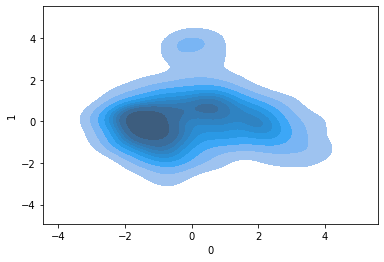

In [16]:
#PCA
sns.kdeplot(data=Xp,x=0,y=1,fill=True)

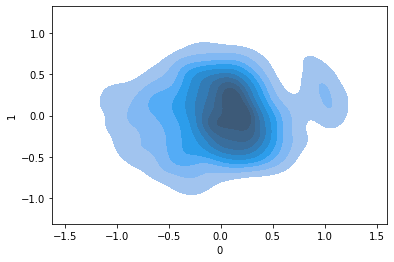

In [17]:
#MDS
sns.kdeplot(data=Xm,x=0,y=1,fill=True)

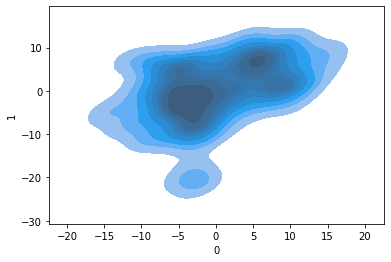

In [18]:
#t-SNE
sns.kdeplot(data=Xt,x=0,y=1,fill=True)

## Clustering

In [19]:
sc = MinMaxScaler()
Xs = pd.DataFrame(sc.fit_transform(x),columns=varc)

### Aglomerativo

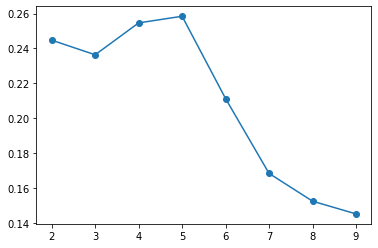

In [20]:
sil = pd.DataFrame(map(lambda k:(k,silhouette_score(Xs,
                                              AgglomerativeClustering(n_clusters=k).fit_predict(Xs))),
                 range(2,10)),columns=['k','sil'])
plt.plot(sil['k'],sil['sil'],marker='o')

In [21]:
k = 5
tipo = 'agg'
agg = AgglomerativeClustering(n_clusters=k)
X[f'cl_{tipo}']=x[f'cl_{tipo}']=Xp[f'cl_{tipo}']=Xm[f'cl_{tipo}']=Xt[f'cl_{tipo}'] =agg.fit_predict(Xs[varc])

### KMedias

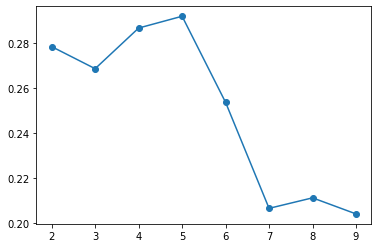

In [22]:
sil = pd.DataFrame(map(lambda k:(k,silhouette_score(Xs,
                                              KMeans(n_clusters=k,max_iter=2000).fit_predict(Xs))),
                 range(2,10)),columns=['k','sil'])
plt.plot(sil['k'],sil['sil'],marker='o')

In [23]:
k = 5
tipo = 'kme'
kme = KMeans(n_clusters=k,max_iter=2000)
X[f'cl_{tipo}']=x[f'cl_{tipo}']=Xp[f'cl_{tipo}']=Xm[f'cl_{tipo}']=Xt[f'cl_{tipo}'] =kme.fit_predict(Xs[varc])

### Modelos Gaussianos Mixtos

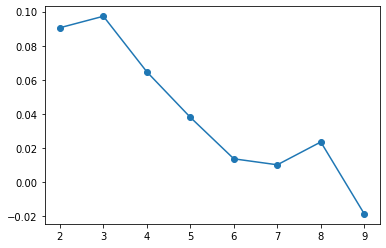

In [24]:
sil = pd.DataFrame(map(lambda k:(k,silhouette_score(Xs,
                                              GaussianMixture(n_components=k,max_iter=1000).fit_predict(Xs))),
                 range(2,10)),columns=['k','sil'])
plt.plot(sil['k'],sil['sil'],marker='o')

In [25]:
k = 3
tipo = 'gmm'
gmm = GaussianMixture(n_components=k,max_iter=1000)
X[f'cl_{tipo}']=x[f'cl_{tipo}']=Xp[f'cl_{tipo}']=Xm[f'cl_{tipo}']=Xt[f'cl_{tipo}'] =gmm.fit_predict(Xs[varc])

### Visualizacion de clusters en 3 dimensiones

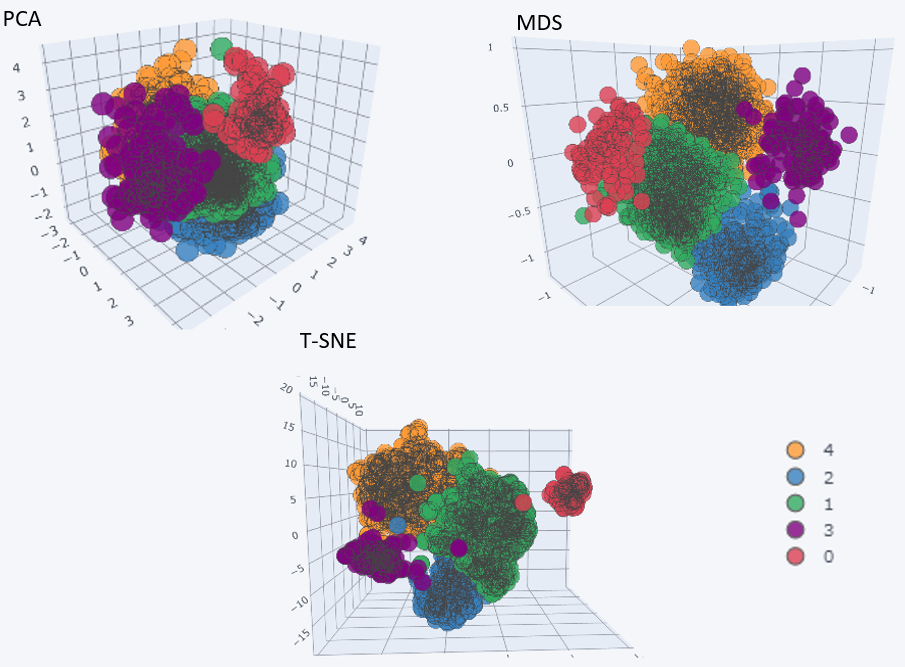

In [27]:
#Seleccionamos la mejor clusterización
selected = 'cl_kme'

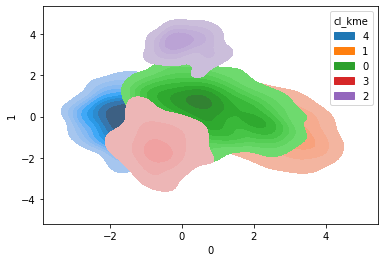

In [28]:
Xp.iplot(kind='scatter3d',x=0,y=1,z=2,mode='markers',categories=selected)
sns.kdeplot(data=Xp,x=0,y=1,fill=True,hue=selected)

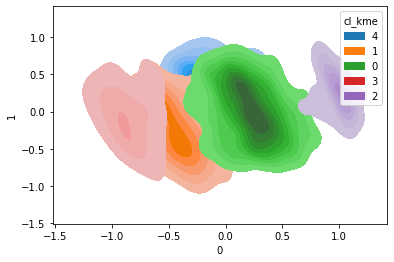

In [29]:
Xm.iplot(kind='scatter3d',x=0,y=1,z=2,mode='markers',categories=selected)
sns.kdeplot(data=Xm,x=0,y=1,fill=True,hue=selected)

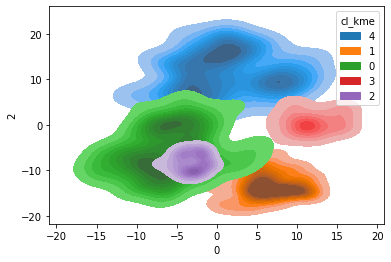

In [30]:
Xt.iplot(kind='scatter3d',x=0,y=1,z=2,mode='markers',categories=selected)
sns.kdeplot(data=Xt,x=0,y=2,fill=True,hue=selected)

In [31]:
#Prueba Kruskal para ver si hay semejanza entre los distintos clusters
v = varc[0]
pd.DataFrame(map(lambda v:(v,
              kruskal(*[d[v].reset_index(drop=True) for cl,d in x[[selected,v]].groupby(selected)]).pvalue),varc),
             columns=['variable','p-value']).round(2)

,variable,p-value
0,c_acousticness,0.0
1,c_danceability,0.0
2,c_duration_ms,0.0
3,c_energy,0.0
4,c_instrumentalness,0.0
5,c_liveness,0.0
6,c_speechiness,0.0
7,c_tempo,0.0
8,c_valence,0.0


## Perfilamiento

### Continuas

c_acousticness


group1,group2,meandiff,p-adj,lower,upper,reject
0,1,0.1192,0.001,0.0879,0.1504,True
0,2,-0.3068,0.001,-0.3565,-0.2571,True
0,3,-0.7399,0.001,-0.7826,-0.6973,True
0,4,-0.6575,0.001,-0.6801,-0.6348,True
1,2,-0.426,0.001,-0.4797,-0.3722,True
1,3,-0.8591,0.001,-0.9064,-0.8118,True
1,4,-0.7767,0.001,-0.8072,-0.7461,True
2,3,-0.4331,0.001,-0.4942,-0.372,True
2,4,-0.3507,0.001,-0.3999,-0.3014,True
3,4,0.0825,0.001,0.0403,0.1246,True


c_danceability


group1,group2,meandiff,p-adj,lower,upper,reject
0,1,-0.0767,0.001,-0.1081,-0.0453,True
0,2,0.1706,0.001,0.1207,0.2205,True
0,3,0.0251,0.4962,-0.0177,0.068,False
0,4,0.087,0.001,0.0642,0.1097,True
1,2,0.2473,0.001,0.1933,0.3013,True
1,3,0.1018,0.001,0.0543,0.1494,True
1,4,0.1636,0.001,0.1329,0.1943,True
2,3,-0.1455,0.001,-0.2069,-0.0841,True
2,4,-0.0837,0.001,-0.1332,-0.0342,True
3,4,0.0618,0.001,0.0194,0.1042,True


c_duration_ms


group1,group2,meandiff,p-adj,lower,upper,reject
0,1,-866.908,0.9,-13641.5073,11907.6913,False
0,2,-52395.2772,0.001,-72708.4612,-32082.0933,True
0,3,57572.3578,0.001,40130.0919,75014.6238,True
0,4,37872.5569,0.001,28605.5995,47139.5142,True
1,2,-51528.3692,0.001,-73504.4636,-29552.2749,True
1,3,58439.2659,0.001,39085.8185,77792.7132,True
1,4,38739.4649,0.001,26241.4739,51237.4559,True
2,3,109967.6351,0.001,84987.8237,134947.4465,True
2,4,90267.8341,0.001,70127.4559,110408.2123,True
3,4,-19699.801,0.0158,-36940.5096,-2459.0923,True


c_energy


group1,group2,meandiff,p-adj,lower,upper,reject
0,1,-0.1048,0.001,-0.1381,-0.0715,True
0,2,-0.1089,0.001,-0.1618,-0.0561,True
0,3,0.4114,0.001,0.366,0.4568,True
0,4,0.3714,0.001,0.3472,0.3955,True
1,2,-0.0041,0.9,-0.0614,0.0531,False
1,3,0.5162,0.001,0.4658,0.5666,True
1,4,0.4762,0.001,0.4436,0.5087,True
2,3,0.5203,0.001,0.4553,0.5854,True
2,4,0.4803,0.001,0.4279,0.5327,True
3,4,-0.04,0.1069,-0.0849,0.0049,False


c_instrumentalness


group1,group2,meandiff,p-adj,lower,upper,reject
0,1,0.7737,0.001,0.7548,0.7926,True
0,2,-0.0376,0.006,-0.0677,-0.0075,True
0,3,0.7207,0.001,0.6948,0.7465,True
0,4,-0.0179,0.0036,-0.0316,-0.0041,True
1,2,-0.8113,0.001,-0.8438,-0.7787,True
1,3,-0.053,0.001,-0.0817,-0.0244,True
1,4,-0.7916,0.001,-0.8101,-0.7731,True
2,3,0.7582,0.001,0.7212,0.7952,True
2,4,0.0197,0.3739,-0.0102,0.0495,False
3,4,-0.7385,0.001,-0.7641,-0.713,True


c_liveness


group1,group2,meandiff,p-adj,lower,upper,reject
0,1,-0.0147,0.2946,-0.0354,0.006,False
0,2,0.0465,0.0011,0.0137,0.0794,True
0,3,0.0028,0.9,-0.0255,0.031,False
0,4,0.0013,0.9,-0.0136,0.0163,False
1,2,0.0612,0.001,0.0257,0.0968,True
1,3,0.0175,0.5408,-0.0138,0.0488,False
1,4,0.0161,0.1919,-0.0042,0.0363,False
2,3,-0.0438,0.0261,-0.0842,-0.0033,True
2,4,-0.0452,0.0015,-0.0778,-0.0126,True
3,4,-0.0014,0.9,-0.0293,0.0265,False


c_speechiness


group1,group2,meandiff,p-adj,lower,upper,reject
0,1,-0.0045,0.9,-0.0187,0.0098,False
0,2,0.8293,0.001,0.8066,0.852,True
0,3,0.0019,0.9,-0.0176,0.0214,False
0,4,0.0154,0.001,0.005,0.0257,True
1,2,0.8338,0.001,0.8092,0.8583,True
1,3,0.0064,0.9,-0.0152,0.028,False
1,4,0.0198,0.001,0.0059,0.0338,True
2,3,-0.8274,0.001,-0.8553,-0.7995,True
2,4,-0.8139,0.001,-0.8364,-0.7914,True
3,4,0.0135,0.3115,-0.0058,0.0327,False


c_tempo


group1,group2,meandiff,p-adj,lower,upper,reject
0,1,-8.7949,0.001,-14.5496,-3.0402,True
0,2,-0.8266,0.9,-9.9773,8.3241,False
0,3,11.3358,0.001,3.4784,19.1932,True
0,4,8.4925,0.001,4.3179,12.6671,True
1,2,7.9683,0.1808,-1.9315,17.8681,False
1,3,20.1307,0.001,11.4124,28.8491,True
1,4,17.2874,0.001,11.6573,22.9175,True
2,3,12.1624,0.0266,0.9095,23.4153,True
2,4,9.3191,0.0407,0.2463,18.392,True
3,4,-2.8433,0.8381,-10.6099,4.9233,False


c_valence


group1,group2,meandiff,p-adj,lower,upper,reject
0,1,-0.0957,0.001,-0.1431,-0.0484,True
0,2,0.0207,0.9,-0.0547,0.096,False
0,3,-0.0458,0.3006,-0.1105,0.0189,False
0,4,0.0919,0.001,0.0575,0.1263,True
1,2,0.1164,0.001,0.0349,0.1979,True
1,3,0.05,0.3174,-0.0218,0.1217,False
1,4,0.1877,0.001,0.1413,0.234,True
2,3,-0.0664,0.2874,-0.1591,0.0262,False
2,4,0.0713,0.07,-0.0034,0.146,False
3,4,0.1377,0.001,0.0738,0.2016,True


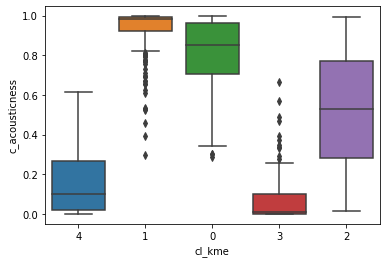

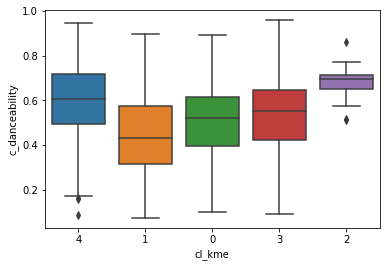

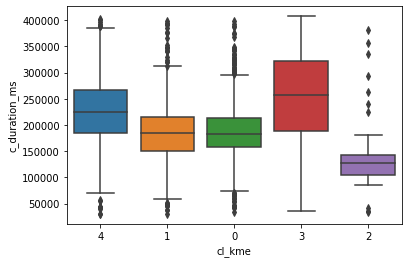

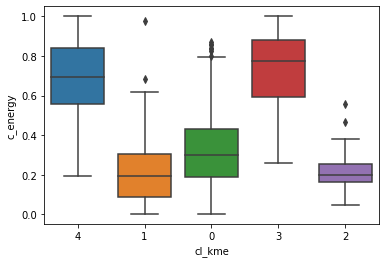

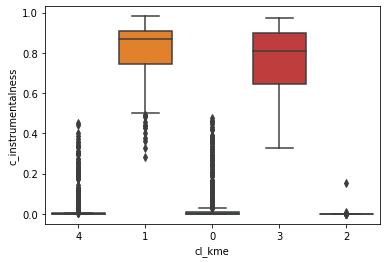

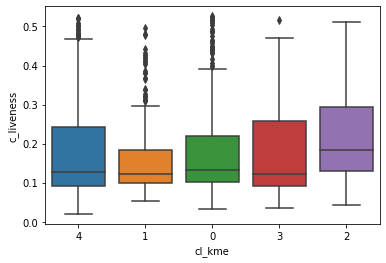

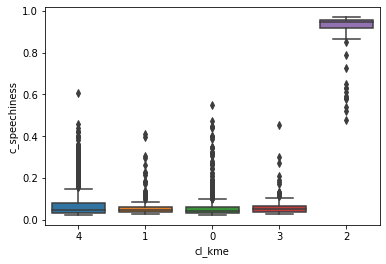

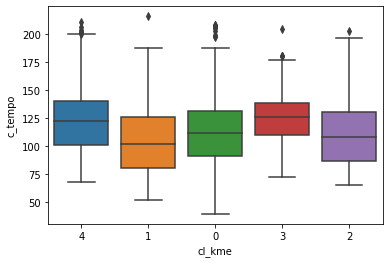

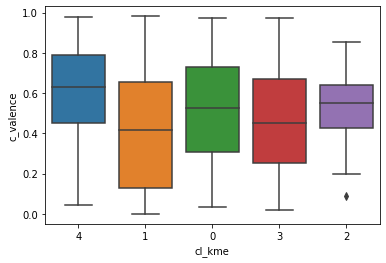

In [32]:
#comparacion de medias por prueba tukey
for v in varc:
    print(v)
    display(MultiComparison(x[v],x[selected]).tukeyhsd().summary())
    plt.figure()
    sns.boxplot(data=x,y=v,x=selected)

## Arquetipos

In [34]:
X[selected].value_counts(1)

4    0.4085
0    0.3470
1    0.1380
3    0.0625
2    0.0440
Name: cl_kme, dtype: float64

In [35]:
display(X[varc+[selected]].groupby(selected).mean())
display(X[varc].mean().to_frame().T)

,c_acousticness,c_danceability,c_duration_ms,c_energy,c_instrumentalness,c_liveness,c_speechiness,c_tempo,c_valence
cl_kme,,,,,,,,,
0,0.814409,0.513167,188602.618156,0.319481,0.039454,0.171791,0.063663,114.850935,0.516998
1,0.933587,0.436483,187735.710145,0.214675,0.813159,0.157076,0.059196,106.056033,0.421255
2,0.507598,0.683795,136207.340909,0.210539,0.001887,0.218317,0.892955,114.024341,0.537651
3,0.074478,0.538310,246174.976000,0.730856,0.760112,0.174550,0.065557,126.186776,0.471217
4,0.156931,0.600119,226475.175031,0.690842,0.021577,0.173140,0.079034,123.343454,0.608917


,c_acousticness,c_danceability,c_duration_ms,c_energy,c_instrumentalness,c_liveness,c_speechiness,c_tempo,c_valence
0,0.50253,0.547184,205246.8045,0.477636,0.182311,0.172531,0.105933,117.778553,0.539382


In [36]:
Xs[selected] = X[selected].reset_index(drop=True)

In [37]:
aux = Xs[varc+[selected]].groupby(selected).mean()
aux

,c_acousticness,c_danceability,c_duration_ms,c_energy,c_instrumentalness,c_liveness,c_speechiness,c_tempo,c_valence
cl_kme,,,,,,,,,
0,0.817680,0.497023,0.420192,0.317858,0.040177,0.300122,0.043490,0.428620,0.527007
1,0.937336,0.410315,0.417895,0.212801,0.828065,0.271045,0.038770,0.378787,0.429408
2,0.509635,0.689954,0.281379,0.208655,0.001922,0.392051,0.919656,0.423937,0.548060
3,0.074775,0.525453,0.572720,0.730214,0.774045,0.305571,0.045491,0.492851,0.480338
4,0.157560,0.595340,0.520529,0.690105,0.021972,0.302786,0.059729,0.476740,0.620707


In [38]:
fig = go.Figure()

for i,row in aux.iterrows():
    fig.add_trace(go.Scatterpolar(r=row.values,
                                  theta=varc,
                                  fill='toself',
                                  name=f'cluster {i}'))
fig.show()

### Perfilamiento de los clusters

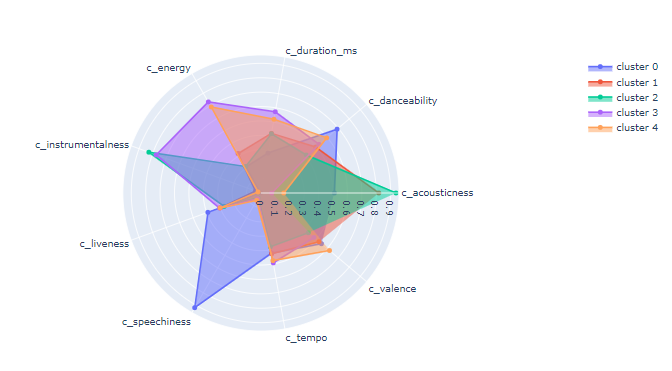